In [1]:
!pip install lxml
!pip install yfinance
!pip install --upgrade mplfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.2 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from datetime import datetime
import yfinance as yf
import mplfinance as mpf
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
table = pd.read_html("https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")

In [4]:
New_table = table[0]

In [5]:
New_table

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Biotechnology,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989
...,...,...,...,...,...,...,...,...
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
499,ZBRA,Zebra Technologies,Information Technology,Electronic Equipment & Instruments,"Lincolnshire, Illinois",2019-12-23,877212,1969
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927
501,ZION,Zions Bancorporation,Financials,Regional Banks,"Salt Lake City, Utah",2001-06-22,109380,1873


In [6]:
New_table_2 = New_table[[datetime.strptime(dt,'%Y-%m-%d') < datetime(2010,1,1) for dt in New_table['Date added']]]

In [7]:
New_table_2

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
5,ADBE,Adobe Inc.,Information Technology,Application Software,"San Jose, California",1997-05-05,796343,1982
7,AES,AES Corporation,Utilities,Independent Power Producers & Energy Traders,"Arlington, Virginia",1998-10-02,874761,1981
8,AFL,Aflac,Financials,Life & Health Insurance,"Columbus, Georgia",1999-05-28,4977,1955
...,...,...,...,...,...,...,...,...
495,WYNN,Wynn Resorts,Consumer Discretionary,Casinos & Gaming,"Paradise, Nevada",2008-11-14,1174922,2002
496,XEL,Xcel Energy,Utilities,Multi-Utilities,"Minneapolis, Minnesota",1957-03-04,72903,1909
498,YUM,Yum! Brands,Consumer Discretionary,Restaurants,"Louisville, Kentucky",1997-10-06,1041061,1997
500,ZBH,Zimmer Biomet,Health Care,Health Care Equipment,"Warsaw, Indiana",2001-08-07,1136869,1927


In [8]:
# My_Tickers = New_table_2["Symbol"].iloc[0:2]
My_Tickers = ["GOOGL","AAPL","AMZN","MSFT","META"]

In [9]:
# My_Tickers.to_list()

In [10]:
Raw_Price_For_My_Tickers = yf.download(tickers=My_Tickers , start='2010-01-04',interval='1d',group_by='ticker')

[*********************100%%**********************]  5 of 5 completed


In [11]:
google = Raw_Price_For_My_Tickers["GOOGL"]
google.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3518 entries, 2010-01-04 to 2023-12-22
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3518 non-null   float64
 1   High       3518 non-null   float64
 2   Low        3518 non-null   float64
 3   Close      3518 non-null   float64
 4   Adj Close  3518 non-null   float64
 5   Volume     3518 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 192.4 KB


In [12]:
close_returns = google['Close'].pct_change()

In [13]:
close_returns_percent = close_returns*100


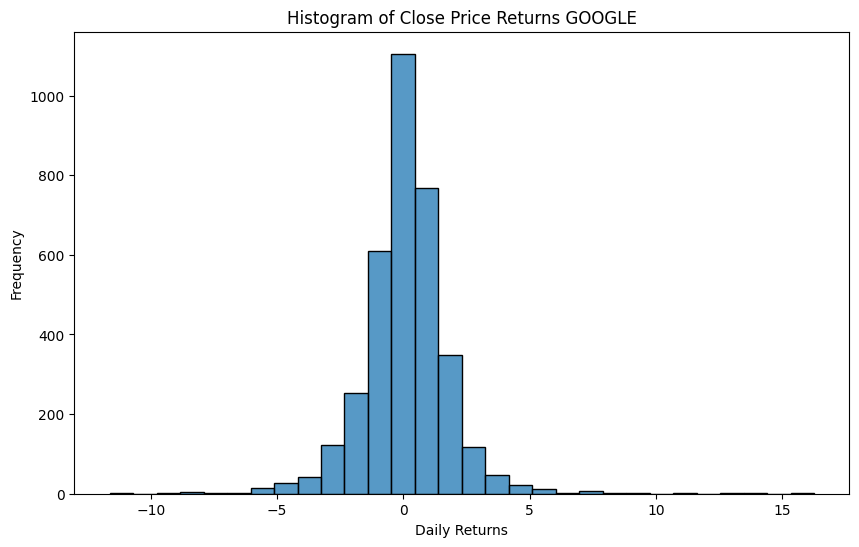

In [14]:


plt.figure(figsize=(10, 6))
sns.histplot(close_returns_percent.dropna(), bins=30)

plt.title('Histogram of Close Price Returns GOOGLE')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.show()

In [15]:
#identify missing timestamps
def print_missing_timestamps(df) :
  complete_date_range = pd.date_range(start=df.index.min(), end=df.index.max())
  missing_dates = set(complete_date_range) - set(df.index)
  if missing_dates:
    print("Missing dates:")
    print(f"total : {len(missing_dates)}")
    for missing_date in sorted(missing_dates):
        print(f"missing : {missing_date}")
  else:
    print("No missing dates.")
sub_set_google = google[google.index > '2023-12'].copy()
print_missing_timestamps(sub_set_google)

Missing dates:
total : 4
missing : 2023-12-09 00:00:00
missing : 2023-12-10 00:00:00
missing : 2023-12-16 00:00:00
missing : 2023-12-17 00:00:00


In [16]:
def fill_missing_timestamps(df):
    start_date = df.index.min()
    end_date = df.index.max()
    date_range = pd.date_range(start=start_date, end=end_date, freq='D')
    missing_dates_df = pd.DataFrame(index=date_range)
    merged_df = pd.merge(missing_dates_df, df, how='left', left_index=True, right_index=True)
    merged_df.interpolate(method='linear', inplace=True)
    merged_df.dropna(inplace=True)
    return merged_df

In [17]:
sub_set_google = fill_missing_timestamps(sub_set_google)


In [18]:
sub_set_google.tail(10)

,Open,High,Low,Close,Adj Close,Volume
2023-12-13,133.380005,133.500000,131.570007,132.570007,132.570007,3.010480e+07
2023-12-14,133.380005,133.720001,129.690002,131.940002,131.940002,3.872240e+07
2023-12-15,131.619995,133.509995,131.179993,132.600006,132.600006,5.081520e+07
2023-12-16,131.956665,134.723328,131.596659,133.666672,133.666672,4.462947e+07
2023-12-17,132.293335,135.936661,132.013326,134.733337,134.733337,3.844373e+07
2023-12-18,132.630005,137.149994,132.429993,135.800003,135.800003,3.225800e+07
2023-12-19,136.839996,137.470001,136.080002,136.649994,136.649994,2.547680e+07
2023-12-20,138.970001,141.699997,138.070007,138.339996,138.339996,4.910720e+07
2023-12-21,139.490005,140.690002,139.179993,140.419998,140.419998,2.746570e+07
2023-12-22,140.770004,141.990005,140.710007,140.929993,140.929993,1.602879e+07


In [19]:
sub_set_google.head(10)

,Open,High,Low,Close,Adj Close,Volume
2023-12-04,129.880005,130.029999,127.900002,129.270004,129.270004,36669900.0
2023-12-05,128.949997,132.139999,128.250000,130.990005,130.990005,27384800.0
2023-12-06,131.440002,131.839996,129.880005,130.020004,130.020004,23576200.0
2023-12-07,135.039993,138.559998,134.699997,136.929993,136.929993,56767100.0
2023-12-08,134.199997,136.399994,134.029999,134.990005,134.990005,32233900.0
2023-12-09,133.593333,135.379995,133.139999,134.423335,134.423335,31868600.0
2023-12-10,132.986669,134.359996,132.250000,133.856664,133.856664,31503300.0
2023-12-11,132.380005,133.339996,131.360001,133.289993,133.289993,31138000.0
2023-12-12,131.809998,133.000000,131.259995,132.520004,132.520004,29032800.0
2023-12-13,133.380005,133.500000,131.570007,132.570007,132.570007,30104800.0


In [20]:
sub_set_google.interpolate(method='linear', inplace=True)

In [21]:
sub_set_google

,Open,High,Low,Close,Adj Close,Volume
2023-12-04,129.880005,130.029999,127.900002,129.270004,129.270004,3.666990e+07
2023-12-05,128.949997,132.139999,128.250000,130.990005,130.990005,2.738480e+07
2023-12-06,131.440002,131.839996,129.880005,130.020004,130.020004,2.357620e+07
2023-12-07,135.039993,138.559998,134.699997,136.929993,136.929993,5.676710e+07
2023-12-08,134.199997,136.399994,134.029999,134.990005,134.990005,3.223390e+07
2023-12-09,133.593333,135.379995,133.139999,134.423335,134.423335,3.186860e+07
2023-12-10,132.986669,134.359996,132.250000,133.856664,133.856664,3.150330e+07
2023-12-11,132.380005,133.339996,131.360001,133.289993,133.289993,3.113800e+07
2023-12-12,131.809998,133.000000,131.259995,132.520004,132.520004,2.903280e+07
2023-12-13,133.380005,133.500000,131.570007,132.570007,132.570007,3.010480e+07


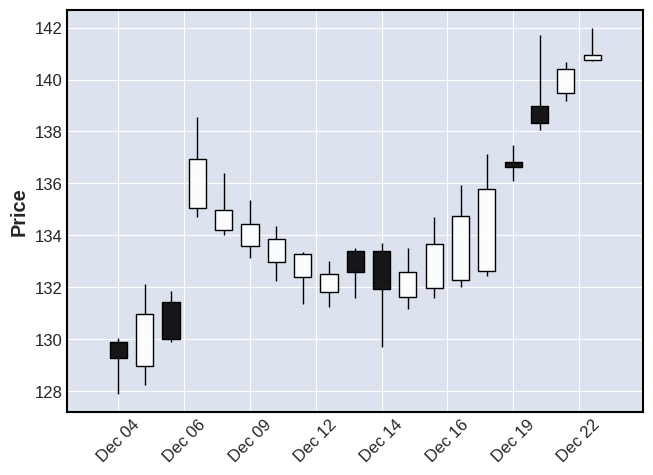

In [22]:
mpf.plot(sub_set_google,type='candle')

In [23]:
cv_n_splits = 5
tss = TimeSeriesSplit(n_splits=5)

In [24]:
print(My_Tickers)

['GOOGL', 'AAPL', 'AMZN', 'MSFT', 'META']


In [25]:
y_tickers_sp500 = []
x_tickers_sp500 = []

def prepare_dataset(tickers : pd.DataFrame,ticker_name : str , window_size =32) :
    X_time_series = []
    Y_time_series = []
    ticker_df = tickers[ticker_name]
    ticker_df = ticker_df.dropna()
    ticker_df = fill_missing_timestamps(ticker_df)
    prices = ticker_df['Open']
    for i in range(window_size, len(prices),window_size) :
        X_time_series.append(prices[i-window_size:i])
        Y_time_series.append(prices[i])

    X_time_series = np.array(X_time_series)
    Y_time_series = np.array(Y_time_series)
    return X_time_series,Y_time_series


google_X , google_Y = prepare_dataset(Raw_Price_For_My_Tickers,'GOOGL')

print(google_X.shape)
print(google_X[0:1])
print(google_Y[0:2])



(159, 32)
[[15.68943882 15.6951952  15.66216183 15.25024986 14.81481457 14.91875203
  15.0226895  15.12662697 14.95620632 14.42667675 14.61211205 14.84834766
  14.77239704 14.69644642 14.6204958  14.54454517 14.66416359 14.6006012
  14.12662697 13.97722721 13.82782745 13.6784277  13.46271324 13.54529476
  13.62587643 13.47572613 13.44327672 13.41082732 13.37837791 13.38738728
  13.22998047 13.43843842]]
[13.22322273 14.01025963]


In [26]:
def normalize_data(train_data, test_data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    print("shape normalize")
    print(train_data.reshape(-1, 1).shape)
    normalized_train_data = scaler.fit_transform(train_data.reshape(-1, 1)).flatten()
    normalized_test_data = scaler.transform(test_data.reshape(-1, 1)).flatten()
    return normalized_train_data, normalized_test_data, scaler

In [27]:

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out





def train_and_evaluate_model(model, ticker, Raw_Price_For_My_Tickers, My_Tickers, window_size, num_epochs=1000, batch_size=64):

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model.to(device)

    X, Y = prepare_dataset(Raw_Price_For_My_Tickers, ticker, window_size)

    # Split the dataset
    split_index = int(0.8 * len(X))
    train_X, test_X = X[:split_index], X[split_index:]
    train_Y, test_Y = Y[:split_index], Y[split_index:]

    # Normalize the data
    train_X_normalized, test_X_normalized, x_scaler = normalize_data(train_X, test_X)
    train_Y_normalized = x_scaler.transform(train_Y.reshape(-1, 1))
    test_Y_normalized = x_scaler.transform(test_Y.reshape(-1, 1))

    # Convert to pytorch
    X_train_tensor = torch.Tensor(train_X_normalized).view(-1, window_size, 1).to(device)
    Y_train_tensor = torch.Tensor(train_Y_normalized).view(-1, 1).to(device)
    X_test_tensor = torch.Tensor(test_X_normalized).view(-1, window_size, 1).to(device)
    Y_test_tensor = torch.Tensor(test_Y_normalized).view(-1, 1).to(device)

    tscv = TimeSeriesSplit(n_splits=5)
    for fold, (train_index, test_index) in enumerate(tscv.split(X_train_tensor)):
        fold_train_X, fold_test_X = X_train_tensor[train_index], X_train_tensor[test_index]
        fold_train_Y, fold_test_Y = Y_train_tensor[train_index], Y_train_tensor[test_index]

        # Dataloader
        train_dataset = TensorDataset(fold_train_X, fold_train_Y)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)

        # train loop
        for epoch in range(num_epochs):
            for inputs, targets in train_loader:
                # Forward pass
                outputs = model(inputs)

                # Compute the loss
                loss = criterion(outputs, targets)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # Evaluate the model on the test set
        model.eval()
        test_outputs = model(X_test_tensor)
        test_loss = criterion(test_outputs, Y_test_tensor)

        # Inverse transform for denormalization
        test_outputs = x_scaler.inverse_transform(test_outputs.detach().cpu().numpy().reshape(-1, 1))
        test_Y = x_scaler.inverse_transform(Y_test_tensor.detach().cpu().numpy().reshape(-1, 1))

        # mse = mean_squared_error(test_Y, test_outputs)
        mae = mean_absolute_error(test_Y, test_outputs)
        mape = np.mean(np.abs((test_Y - test_outputs) / test_Y)) * 100

        print(f'Ticker: {ticker}, Fold {fold + 1}, Validation MSE: {test_loss.item():.4f}, MAE: {mae:.4f}, MAPE: {mape:.4f}')
    return model




In [41]:
My_Tickers = ["GOOGL", "AAPL", "AMZN", "MSFT", "META"]
trained_models = {}
#Hyper params
input_size = 1  # 'Open' is the only feature
hidden_size = 50
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 30
batch_size = 64
window_size = 32
for ticker in My_Tickers:
    model = LSTMModel(input_size, hidden_size, num_layers, output_size)
    trained_model = train_and_evaluate_model(model, ticker, Raw_Price_For_My_Tickers, My_Tickers, window_size)
    trained_models[ticker] = trained_model

Using device: cuda
shape normalize
(4064, 1)
Ticker: GOOGL, Fold 1, Validation MSE: 0.0998, MAE: 27.2094, MAPE: 21.5565
Ticker: GOOGL, Fold 2, Validation MSE: 0.0260, MAE: 13.1841, MAPE: 10.2471
Ticker: GOOGL, Fold 3, Validation MSE: 0.0921, MAE: 27.3107, MAPE: 22.1005
Ticker: GOOGL, Fold 4, Validation MSE: 0.0254, MAE: 13.7945, MAPE: 10.9570
Ticker: GOOGL, Fold 5, Validation MSE: 0.0217, MAE: 12.6649, MAPE: 10.0345
Using device: cuda
shape normalize
(4064, 1)
Ticker: AAPL, Fold 1, Validation MSE: 0.4593, MAE: 91.0120, MAPE: 57.4027
Ticker: AAPL, Fold 2, Validation MSE: 0.2200, MAE: 63.1811, MAPE: 40.0942
Ticker: AAPL, Fold 3, Validation MSE: 0.0507, MAE: 29.8052, MAPE: 18.7477
Ticker: AAPL, Fold 4, Validation MSE: 0.0062, MAE: 10.4662, MAPE: 6.7762
Ticker: AAPL, Fold 5, Validation MSE: 0.0060, MAE: 9.3507, MAPE: 5.7072
Using device: cuda
shape normalize
(4064, 1)
Ticker: AMZN, Fold 1, Validation MSE: 0.2143, MAE: 76.2006, MAPE: 54.7192
Ticker: AMZN, Fold 2, Validation MSE: 0.1809, MAE

In [42]:

class BiLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BiLSTMModel, self).__init__()
        self.bilstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)  # Multiply by 2 for bidirectional

    def forward(self, x):
        out, _ = self.bilstm(x)

        out = self.fc(out[:, -1, :])
        return out

input_size = 1  # 'Open' is the only feature
hidden_size = 50
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 30
batch_size = 64
window_size = 32
for ticker in My_Tickers:
    print("training bi-lstm")
    model = BiLSTMModel(input_size, hidden_size, num_layers, output_size)
    train_and_evaluate_model(model, ticker, Raw_Price_For_My_Tickers, My_Tickers, window_size)


training bi-lstm
Using device: cuda
shape normalize
(4064, 1)
Ticker: GOOGL, Fold 1, Validation MSE: 0.5626, MAE: 69.4119, MAPE: 57.1778
Ticker: GOOGL, Fold 2, Validation MSE: 0.3622, MAE: 55.4438, MAPE: 45.5141
Ticker: GOOGL, Fold 3, Validation MSE: 0.1003, MAE: 28.6526, MAPE: 23.2479
Ticker: GOOGL, Fold 4, Validation MSE: 0.0165, MAE: 11.0074, MAPE: 8.7131
Ticker: GOOGL, Fold 5, Validation MSE: 0.0118, MAE: 8.4254, MAPE: 6.6147
training bi-lstm
Using device: cuda
shape normalize
(4064, 1)
Ticker: AAPL, Fold 1, Validation MSE: 0.3023, MAE: 73.8413, MAPE: 46.5745
Ticker: AAPL, Fold 2, Validation MSE: 0.0726, MAE: 35.5902, MAPE: 22.2375
Ticker: AAPL, Fold 3, Validation MSE: 0.0287, MAE: 21.7065, MAPE: 13.3875
Ticker: AAPL, Fold 4, Validation MSE: 0.0182, MAE: 17.1879, MAPE: 10.5780
Ticker: AAPL, Fold 5, Validation MSE: 0.0263, MAE: 21.0822, MAPE: 13.0724
training bi-lstm
Using device: cuda
shape normalize
(4064, 1)
Ticker: AMZN, Fold 1, Validation MSE: 0.1288, MAE: 58.8529, MAPE: 42.136

In [44]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = 1  # 'Open' is the only feature
hidden_size = 50
num_layers = 2
output_size = 1
learning_rate = 0.001
num_epochs = 30
batch_size = 64
window_size = 32
for ticker in My_Tickers:
    print("training GRU")
    model = GRUModel(input_size, hidden_size, num_layers, output_size)
    train_and_evaluate_model(model, ticker, Raw_Price_For_My_Tickers, My_Tickers, window_size)

training GRU
Using device: cuda
shape normalize
(4064, 1)
Ticker: GOOGL, Fold 1, Validation MSE: 0.1356, MAE: 33.4050, MAPE: 27.1502
Ticker: GOOGL, Fold 2, Validation MSE: 0.0483, MAE: 19.2555, MAPE: 15.3788
Ticker: GOOGL, Fold 3, Validation MSE: 0.0532, MAE: 20.3916, MAPE: 16.3538
Ticker: GOOGL, Fold 4, Validation MSE: 0.0164, MAE: 10.8304, MAPE: 8.5307
Ticker: GOOGL, Fold 5, Validation MSE: 0.0566, MAE: 22.2217, MAPE: 18.4773
training GRU
Using device: cuda
shape normalize
(4064, 1)
Ticker: AAPL, Fold 1, Validation MSE: 0.0615, MAE: 32.5190, MAPE: 20.2518
Ticker: AAPL, Fold 2, Validation MSE: 0.0219, MAE: 18.9470, MAPE: 11.6785
Ticker: AAPL, Fold 3, Validation MSE: 0.0137, MAE: 14.7624, MAPE: 9.0574
Ticker: AAPL, Fold 4, Validation MSE: 0.0127, MAE: 14.3999, MAPE: 8.8747
Ticker: AAPL, Fold 5, Validation MSE: 0.0097, MAE: 12.4804, MAPE: 7.6823
training GRU
Using device: cuda
shape normalize
(4064, 1)
Ticker: AMZN, Fold 1, Validation MSE: 0.0191, MAE: 21.7076, MAPE: 15.1004
Ticker: AMZ

In [45]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MLP, self).__init__()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.Tanh())

        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())

        layers.append(nn.Linear(hidden_size, output_size))  # Adjusted output size

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = self.model(x)
        x = x[:, -1, :]
        return x

# Other parameters
input_size = 1
hidden_size = 50
num_layers = 8
output_size = 1  # Adjusted output size

# Rest of your code
for ticker in My_Tickers:
    print(f"training MLP on {ticker}")
    model = MLP(input_size, hidden_size, num_layers, output_size)
    train_and_evaluate_model(model, ticker, Raw_Price_For_My_Tickers, My_Tickers, window_size)


training MLP on GOOGL
Using device: cuda
shape normalize
(4064, 1)
Ticker: GOOGL, Fold 1, Validation MSE: 1.1279, MAE: 98.7304, MAPE: 81.6515
Ticker: GOOGL, Fold 2, Validation MSE: 0.9206, MAE: 88.9952, MAPE: 73.4504
Ticker: GOOGL, Fold 3, Validation MSE: 0.5401, MAE: 67.7109, MAPE: 55.5849
Ticker: GOOGL, Fold 4, Validation MSE: 0.2628, MAE: 46.6324, MAPE: 37.9570
Ticker: GOOGL, Fold 5, Validation MSE: 0.1100, MAE: 29.4227, MAPE: 23.6309
training MLP on AAPL
Using device: cuda
shape normalize
(4064, 1)
Ticker: AAPL, Fold 1, Validation MSE: 1.0756, MAE: 140.3803, MAPE: 89.0913
Ticker: AAPL, Fold 2, Validation MSE: 0.8841, MAE: 127.0213, MAPE: 80.4747
Ticker: AAPL, Fold 3, Validation MSE: 0.7798, MAE: 119.1380, MAPE: 75.3973
Ticker: AAPL, Fold 4, Validation MSE: 0.6754, MAE: 110.6910, MAPE: 69.9594
Ticker: AAPL, Fold 5, Validation MSE: 0.4542, MAE: 90.2390, MAPE: 56.7970
training MLP on AMZN
Using device: cuda
shape normalize
(4064, 1)
Ticker: AMZN, Fold 1, Validation MSE: 0.3431, MAE: 9

In [46]:
class ConvModel(nn.Module):
    def __init__(self, input_channels, output_size):
        super(ConvModel, self).__init__()
        self.tanh = nn.Tanh()
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=16, kernel_size=1, stride=1)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=1, stride=1, padding=1)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=1, stride=1)
        self.global_avg_pooling = nn.AdaptiveAvgPool1d(1)  # Global average pooling
        self.fc = nn.Linear(64, output_size)

    def forward(self, x):
        # print(x.shape)
        x = self.tanh(self.conv1(x))
        x = self.tanh(self.conv2(x))
        x = self.tanh(self.conv3(x))
        x = self.global_avg_pooling(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)
        return x

# Hyperparams
input_channels = 32
output_size = 1
learning_rate = 0.001
num_epochs = 10
batch_size = 16
window_size = 32

# Create an instance of the model


for ticker in My_Tickers:
    print("training convolution with kernel size 1 ")
    model = ConvModel(input_channels, output_size)
    train_and_evaluate_model(model, ticker, Raw_Price_For_My_Tickers, My_Tickers, window_size)

training convolution with kernel size 1 
Using device: cuda
shape normalize
(4064, 1)
Ticker: GOOGL, Fold 1, Validation MSE: 0.6057, MAE: 71.5775, MAPE: 58.6849
Ticker: GOOGL, Fold 2, Validation MSE: 0.5397, MAE: 67.3621, MAPE: 55.1097
Ticker: GOOGL, Fold 3, Validation MSE: 0.4572, MAE: 61.7227, MAPE: 50.3471
Ticker: GOOGL, Fold 4, Validation MSE: 0.2001, MAE: 39.7528, MAPE: 31.9495
Ticker: GOOGL, Fold 5, Validation MSE: 0.0927, MAE: 26.4591, MAPE: 21.0560
training convolution with kernel size 1 
Using device: cuda
shape normalize
(4064, 1)
Ticker: AAPL, Fold 1, Validation MSE: 0.6665, MAE: 109.8543, MAPE: 69.3822
Ticker: AAPL, Fold 2, Validation MSE: 0.4208, MAE: 86.9214, MAPE: 54.7447
Ticker: AAPL, Fold 3, Validation MSE: 0.2967, MAE: 72.4633, MAPE: 45.4338
Ticker: AAPL, Fold 4, Validation MSE: 0.2489, MAE: 66.0831, MAPE: 41.3318
Ticker: AAPL, Fold 5, Validation MSE: 0.1547, MAE: 51.3110, MAPE: 31.8556
training convolution with kernel size 1 
Using device: cuda
shape normalize
(4064,

In [47]:
def naive_forecast(Raw_Price_For_My_Tickers, ticker , window_size):
  X, Y = prepare_dataset(Raw_Price_For_My_Tickers, ticker, window_size)
  split_index = int(0.8 * len(X))
  train_X, test_X = X[:split_index], X[split_index:]
  train_Y, test_Y = Y[:split_index], Y[split_index:]
  predictions = []
  for inputs in test_X :
    predictions.append(inputs[-1])
  # since this is naive forecast there is no training but for consistency we evalute on train set
  mse_test = mean_squared_error(test_Y, predictions)
  mae_test = mean_absolute_error(test_Y, predictions)
  mape_test = np.mean(np.abs((test_Y - predictions) / test_Y)) * 100
  print(f"Ticker: {ticker}")
  print(f"MSE: {mse_test:.4f}, MAE: {mae_test:.4f}, MAPE: {mape_test:.4f}")



for ticker in My_Tickers:
  naive_forecast( Raw_Price_For_My_Tickers, ticker, window_size)


Ticker: GOOGL
MSE: 1.0429, MAE: 0.6387, MAPE: 0.5193
Ticker: AAPL
MSE: 3.1033, MAE: 1.1825, MAPE: 0.7625
Ticker: AMZN
MSE: 9.8102, MAE: 1.7276, MAPE: 1.2917
Ticker: MSFT
MSE: 9.8587, MAE: 2.2409, MAPE: 0.7802
Ticker: META
MSE: 12.6338, MAE: 2.5399, MAPE: 1.0920


In [48]:
# print(X_test_tensor.shape)
# print(X_test_tensor[8])
# print(Y_test_tensor[8])
# print(X_test_tensor[9])


In [49]:

def plot_auto_regressive(model, X_test_tensor, x_scaler):

    random_index = np.random.randint(0, len(X_test_tensor) - 2)

    # Prepare input for auto-regressive prediction
    auto_reg_input = X_test_tensor[random_index]
    y_true = X_test_tensor[random_index + 1]

    auto_reg_predictions = []
    for _ in range(len(y_true)):
        auto_reg_output = model(auto_reg_input.unsqueeze(0))
        auto_reg_input = torch.cat([auto_reg_input[1:], auto_reg_output], dim=0)
        auto_reg_predictions.append(auto_reg_output.squeeze().item())


    auto_reg_predictions = x_scaler.inverse_transform(np.array(auto_reg_predictions).reshape(-1, 1))
    y_true = x_scaler.inverse_transform(np.array(y_true).reshape(-1, 1))

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='Real Values', linestyle='-', marker='o', markersize=5)
    plt.plot(auto_reg_predictions, label='Predicted Values (Auto-regressive)', linestyle='--', marker='o', markersize=5)
    plt.title('Predicted vs. Real Values')
    plt.xlabel('Time Step')
    plt.ylabel('Open Price')
    plt.legend()
    plt.show()




plot_auto_regressive(model, X_test_tensor, x_scaler)


NameError: ignored